### CS 484/684 Computational Vision, University of Waterloo (instructor: Y. Boykov)
# Example - Deep Learning for  Classification
### Credits: design and code development for this notebook was mainly done by Teaching Assistant (2019) Towaki Takikawa (tovacinni@gmail.com).

In [1]:
%matplotlib inline

# This notebook is fust enough on CPU (even the "training" cell takes only 4-5 minutes) 
# so we recommend that you keep GPU off, as below.
USE_GPU = False  

In [2]:
# Python Libraries
import random
import math
import numbers

# Importing essential libraries for basic image manipulations.
import numpy as np
import PIL
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from tqdm import tqdm

# We import some of the main PyTorch and TorchVision libraries used for HW4.
# Detailed installation instructions are here: https://pytorch.org/get-started/locally/
# That web site should help you to select the right 'conda install' command to be run in 'Anaconda Prompt'.
# In particular, select the right version of CUDA. Note that prior to installing PyTorch, you should  
# install the latest driver for your GPU and CUDA (9.2 or 10.1), assuming your GPU supports it. 
# For more information about pytorch refer to 
# https://pytorch.org/docs/stable/nn.functional.html
# https://pytorch.org/docs/stable/data.html.
# and https://pytorch.org/docs/stable/torchvision/transforms.html
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim

from torchvision.datasets import FashionMNIST
from torchvision.datasets import MNIST

# These imported libraries provide useful functions that help
#  not have to explicitly implement some of the nitty-gritty
#  details of doing deep learning for images.
# Refer to https://pytorch.org/docs/stable/torchvision/transforms.html
import torchvision.transforms as transforms

In [3]:
# We will use this sample dataset to run our transforms on
#  individual images. Running this block will automatically 
#  download the FashionMNIST Dataset to DATASET_PATH.
#  Modify this function as needed if you want to download
#  the dataset to a custom directory.

DATASET_PATH = 'datasets'

sample_data = FashionMNIST(
    DATASET_PATH, 
    train = True, 
    download = True,   # set this to False in later runs (after the database is downloaded)
)

labels = {
    0: 'shirt',
    1: 'trouser',
    2: 'pullover',
    3: 'dress',
    4: 'coat',
    5: 'sandal',
    6: 'shirt',
    7: 'sneaker',
    8: 'bag',
    9: 'ankle boot'
}

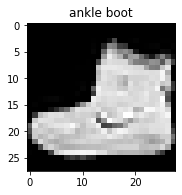

In [4]:
# Here, we show how to obtain a single img, target pair
#  from our sample dataset and visualize it.

sample = sample_data[0]

img, target = sample

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(2,2,1)
plt.title(labels[int(target)])
ax1.imshow(img, cmap="gray")

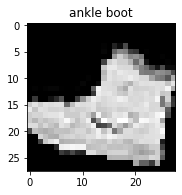

In [5]:
# We will now show some sample transformations.
# These transformations are useful to augment our dataset
# with more samples to learn from. Here, we demonstrate a
# random rotation as well as a color jitter.

sample_transform = transforms.Compose([
    transforms.RandomRotation([-15,15]),
    transforms.ColorJitter(0.5, 0.2, 0.1)
])

img_t = sample_transform(img)    
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(2,2,1)
plt.title(labels[int(target)])
ax1.imshow(img_t, cmap="gray")

In [6]:
# We now create transforms to apply on our datasets.

train_transform = transforms.Compose([
    transforms.RandomRotation([-15,15]),
    transforms.ColorJitter(0.5, 0.2, 0.1), 
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # mean and variance for image intensities in the dataset
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # mean and variance for image intensities in the dataset
])

In [7]:
# We apply the transforms to the datasets.

train_data = FashionMNIST(
    DATASET_PATH, 
    train = True, 
    transform = train_transform
)

val_data = FashionMNIST(
    DATASET_PATH, 
    train = False, 
    transform = val_transform
)

train_loader = DataLoader(train_data, batch_size=32, num_workers=4, shuffle=True)
val_loader = DataLoader(val_data, batch_size=4, num_workers=4, shuffle=False)

## Network implementation 
#### The network structure is illustrated in the diagram posted next to the notebook link (CS484 web page, Code tab) and in topic 10 of CS484 lecture slides.

In [8]:
import torchvision.models as models

# We create a very simple model to perform classification.

class MyNet(nn.Module):
    def __init__(self, criterion=None):
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
        self.criterion = criterion

    def forward(self, x, gts=None):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.dropout(x, 0.7)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.7)
        x = self.fc2(x)
        out = F.log_softmax(x, dim=1)
    
        if self.training:
            return self.criterion(out, gts)              
        else:
            return out

## Evaluation of untrainied network

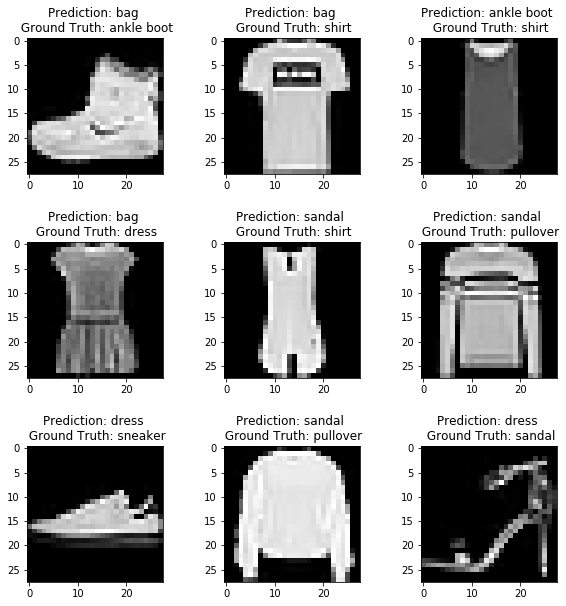

In [9]:
net = MyNet().eval()

fig = plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.5)

for i in range(9):
    sample_img, sample_target = sample_data[i]
    sample_img = transforms.ToTensor()(sample_img)
    sample_output = net.forward(sample_img[None])


    ax1 = fig.add_subplot(3,3,i+1)
    plt.title("Prediction: {} \n Ground Truth: {}".format(
        labels[int(torch.argmax(sample_output).numpy())],
        labels[int(sample_target)]    
    ))
    ax1.imshow(sample_data[i][0], cmap="gray")

In [10]:
def confusion_matrix(preds, targets, conf_matrix):
    preds = torch.argmax(preds, 1)
    for p, t in zip(preds, targets):
        conf_matrix[p, t] += 1

In [11]:
# Validation Loop

def validate(val_loader, net, vis=True):
    
    conf_matrix = torch.zeros(10, 10)
    
    iou_arr = []
    
    net.eval()
    val_loss = 0
    correct = 0
    
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            
            inputs, target = data

            if USE_GPU:
                inputs = inputs.cuda()
                target = target.cuda()
                net = net.cuda()

            output = net(inputs)
            val_loss += F.nll_loss(output, target, reduction='sum').item() 
            pred = output.argmax(dim=1, keepdim=True) 
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            confusion_matrix(output, target, conf_matrix)
    
    val_loss /= len(val_loader.dataset)

    if vis:
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            val_loss, correct, len(val_loader.dataset),
            100. * correct / len(val_loader.dataset)))
    
        plt.title('Confusion Matrix')
        plt.imshow(conf_matrix, cmap='viridis', interpolation='nearest')
        plt.colorbar()
        plt.xticks(np.arange(10), labels.values(), rotation='vertical')
        plt.yticks(np.arange(10), labels.values())
        plt.show()
        
    net.train()
    return correct / len(val_loader.dataset)



Test set: Average loss: 2.3444, Accuracy: 969/10000 (10%)



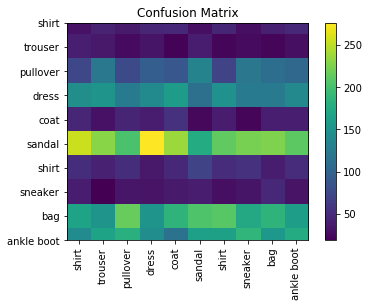

0.0969

In [12]:
validate(val_loader, net)

## Network training

In [13]:
def get_optimizer(net):
    optimizer = torch.optim.SGD(net.parameters(),
                                lr=0.001,
                                weight_decay=1e-5,
                                momentum=0.5,
                                nesterov=False)
    return optimizer

In [14]:
# Training Loop

def train(train_loader, net, optimizer, loss_graph):
    
    for i, data in enumerate(train_loader):
        
        inputs, target = data

        if USE_GPU:
            inputs = inputs.cuda()
            net = net.cuda()
            target = target.cuda()
        
        optimizer.zero_grad()
        main_loss = net(inputs, gts=target)
        loss_graph.append(main_loss.item())
        main_loss.backward()
        optimizer.step()

    return main_loss

1875
Starting Training...


<IPython.core.display.Javascript object>


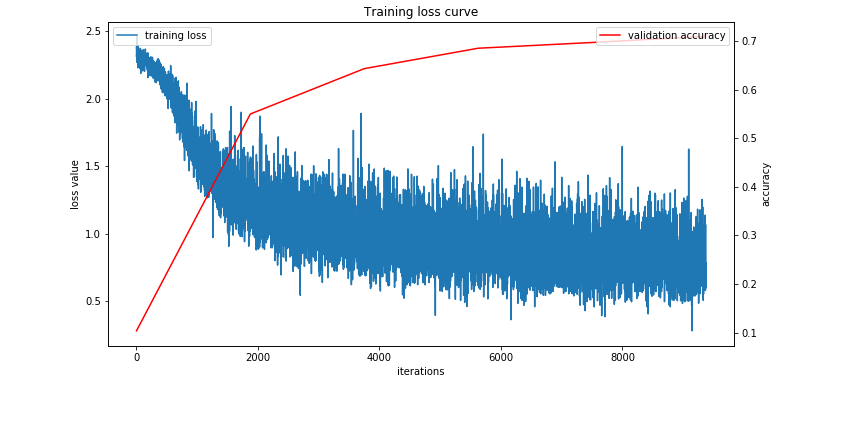

Epoch: 0 Loss: 1.2635940313339233
Epoch: 1 Loss: 0.9927514791488647
Epoch: 2 Loss: 1.0972548723220825
Epoch: 3 Loss: 1.006178855895996
Epoch: 4 Loss: 0.6295835971832275
Wall time: 4min 12s


In [15]:
%%time
%matplotlib notebook

EPOCH = 5

net = MyNet(criterion=F.nll_loss)
optimizer = get_optimizer(net)

print(len(train_loader))

print("Starting Training...")

loss_graph = []
val_idx = [0]
val_graph = []
val_graph.append(validate(val_loader, net, vis=False))
    
fig = plt.figure(figsize=(12,6))
plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
ax1 = fig.add_subplot(1,1,1)

ax2 = ax1.twinx()

for e in range(EPOCH):
    loss = train(train_loader, net, optimizer, loss_graph)
    
    val_idx.append((e + 1) * len(train_loader))
    val_graph.append(validate(val_loader, net, vis=False))
    ax1.clear()
    ax1.set_xlabel('iterations')
    ax1.set_ylabel('loss value')
    ax1.set_title('Training loss curve')
    ax1.plot(loss_graph, label='training loss')
    ax1.legend(loc='upper left')
    
    ax2.clear()
    ax2.set_ylabel('accuracy')
    ax2.plot(val_idx, val_graph, label='validation accuracy', color='red')
    ax2.legend(loc='upper right')
    fig.canvas.draw()
    print("Epoch: {} Loss: {}".format(e, loss))
    
%matplotlib inline

## Evaluation of the trained network

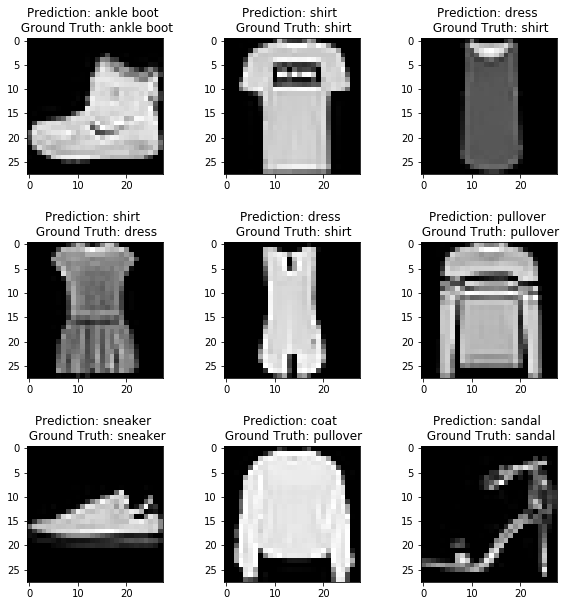

In [16]:
net = net.eval()

fig = plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.5)

for i in range(9):
    sample_img, sample_target = sample_data[i]
    sample_img = transforms.ToTensor()(sample_img)
    sample_img = transforms.Normalize((0.1307,), (0.3081,))(sample_img)
    sample_output = net.forward(sample_img[None])

    ax1 = fig.add_subplot(3,3,i+1)
    plt.title("Prediction: {} \n Ground Truth: {}".format(
        labels[int(torch.argmax(sample_output).numpy())],
        labels[int(sample_target)]    
    ))
    ax1.imshow(sample_data[i][0], cmap = "gray")


Test set: Average loss: 0.7672, Accuracy: 7122/10000 (71%)



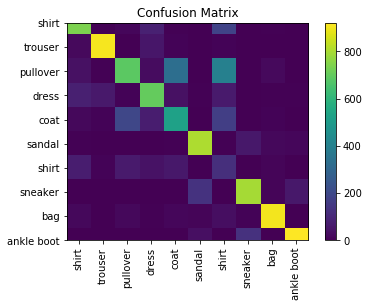

0.7122

In [17]:
validate(val_loader, net)